# Numeric Methods Commonly Used in HARK

In [1]:
import numpy as np
from HARK.utilities import plot_funcs
from HARK.interpolation import LinearInterp, CubicInterp

HARK uses a variety of numeric methods to solve and simulate models; this notebook discusses some of those methods. Much of what's done in HARK (and described here) is commonly known, but there are some less-than-common techniques as well.

## The Endogenous Grid Method

Essentially all consumption-saving models in HARK are solved using the **endogenous grid method**, or EGM for short. This technique was first published in 2005, but Chris Carroll had been using it for over a decade before then-- and believed that everyone else was using it too! It has since been extended by many others to incorporate wider arrays of models, but the main logic remains the same.

### Simple Consumption-Saving Model

We'll present a very basic consumption-saving model here to quickly motivate the EGM:

\begin{eqnarray*}
V_t(M_t) &=& \max_{C_t} U(C_t) + \beta \mathbb{E} \left[ V_{t+1}(M_{t+1})\right] ~~ \text{s.t.}\\
A_t &=& M_t - C_t,\\
A_t &\geq& 0,\\
M_{t+1} &=& R A_t + Y_{t+1},\\
Y_{t+1} &\sim& F,\\
U(C) &=& \frac{C^{1-\rho}}{1-\rho}.
\end{eqnarray*}

This is a basic consumption-saving framework with iid income drawn from some distribution $F$, CRRA utility, geometric discounting, and one risk-free asset. The problem in period $t$ is to find optimal consumption $C_t$ as a function of market resources $M_t$, subject to income risk and assuming that the problem has already been solved back to period $t+1$. For simplicity, let's assume that $V_{t+1}(\cdot)$ is strictly concave (it *is* strictly concave if this is the model in all future periods, but we won't bother proving that here).

### Traditional Solution Method

Assuming an interior solution for $C_t$, the first order condition for optimality is the first derivative of the maximand with respect to $C_t$, equated to zero:

\begin{equation*}
\text{maximand:} ~~ \frac{C_t^{1-\rho}}{1-\rho} + \beta \mathbb{E} \left[ V_{t+1}(R (M_t - C_t) + Y_{t+1})\right].
\end{equation*}
\begin{equation*}
\text{FOC:} ~~ C_t^{-\rho} - \beta R \mathbb{E} \left[ V_{t+1}'(R (M_t - C_t) + Y_{t+1})\right] = 0.
\end{equation*}

The "traditional" way to solve this model is to choose a finite grid of $M_t$ values, then search for the $C_t$ that satisfies the FOC for each one. That is, we suppose that the agent *is* at some state $M_t$ and ask *what they should optimally do now*.

This approach involves using a numeric rootfinder to solve the FOC; each "guess" of $C_t$ for some $M_t$ requires computing the expectation over $Y_{t+1}$. This is a costly process that involves a lot of "wasted work": if a pair $(M_t,C_t)$ does not satisfy the FOC, we *throw it out* and try again.

### Endogenous Grid Method Math

The endogenous grid method eliminates that wasted work by flipping the problem around. Rather than considering what the agent should do *now* at some $M_t$, it instead hypothesizes that the agent has *already* consumed and is *ending* the period with $A_t$ in retained assets. EGM asks how much the agent must have *just consumed* if they acted optimally and ended the period with $A_t$.

Mathematically, this involves defining the agent's "end-of-period value function", sometimes called a "continuation value function". It maps from values of $A_t$ to the expected sum of future utility flows.

\begin{equation*}
\mathfrak{V}_t(A_t) = \beta \mathbb{E} \left[ V_t(R A_t + Y_{t+1}) \right].
\end{equation*}

The marginal value of end-of-period assets is:

\begin{equation*}
\mathfrak{V}_t'(A_t) = \beta R \mathbb{E} \left[ V_t'(R A_t + Y_{t+1}) \right].
\end{equation*}

The first order condition for optimality can thus be re-expressed in "EGM form" using these definitions:

\begin{equation*}
\text{maximand:} ~~ \frac{C_t^{1-\rho}}{1-\rho} + \mathfrak{V}_t(A_t).
\end{equation*}

\begin{equation*}
\text{FOC:} ~~ C_t^{-\rho} - \mathfrak{V}_t'(A_t) = 0.
\end{equation*}

The FOC in EGM form can be solved very easily to find $C_t$:

\begin{equation*}
C_t = \mathfrak{V}_t'(A_t)^{-1/\rho}.
\end{equation*}

Moreover, if we know end-of-period assets $A_t$ and how much the agent just consumed $C_t$, we also know how much market resources $M_t$ they had when they made their decision, from the intraperiod budget constraint:

\begin{equation*}
A_t = M_t - C_t \Longrightarrow M_t = A_t + C_t.
\end{equation*}

### Algorithm Summary

The preceding math suggests the following general algorithm for EGM:

1. Choose a grid of end-of-period states $A_t$ on $[0, \infty]$
2. Evaluate marginal value of end-of-period assets $\mathfrak{V}_t'(A_t)$ for each gridpoint
3. Find the associated optimal $C_t$ for each $A_t$ using the inverted FOC
4. Find the $M_t$ gridpoint from which $C_t$ was chosen to reach each $A_t$
5. Add an additional $(M_t, C_t)$ gridpoint at $(0,0)$
6. Construct the consumption function as a linear interpolation of $C_t$ on $M_t$
7. Represent the marginal value function $V_t'(M_t)$ as the composition of the marginal utility function and the consumption function

The final step relies on the typical envelope condition for consumption-saving models, which we don't elaborate on here.

EGM greatly accelerates solving the model because it yields one point on the consumption function for each numeric expectation (over future marginal value) that is computed. That is, there is no "wasted work" at all. Moreover, EGM *exactly* identifies where the borrowing constraint $A_t \geq 0$ begins to bind. In contrast, the "standard approach" involves checking various $M_t$ values and finding that the agent should consume all market resources, but never finds the exact point where $C_t = M_t$ exactly satisfies the FOC.

Essentially all of the consumption-saving models in HARK are more complex than the example here, and thus the math is somewhat more complicated in practice. But the core logic is the same: consider the agent's (marginal) valuation from the perspective of the *end* of the period and recover their optimal control(s) from that.

Throughout HARK's solvers, the prefix `EndOfPrd` is used to denote "end-of-period" objects and values. E.g. `EndOfPrd_vP` is marginal value as of the end of period $t$.

## Interpolation Methods

HARK includes many interpolator classes in `HARK.interpolation`. We use custom interpolation code to enable compatibility with the concept of "distance" between objects (as part of `MetricObject`).

### Linear Spline Interpolation

The most common interpolation technique in HARK is basic linear spline interpolation using `LinearInterp`. The basic syntax for making a linear splint interpolant is simple: `LinearInterp(x_values, y_values)`. Let's make an approximation of the log function as a demonstration.

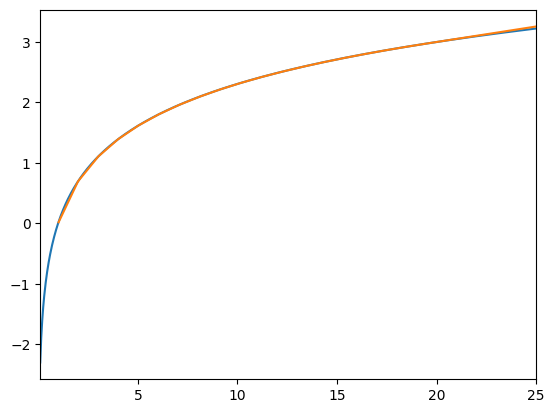

In [2]:
f = np.log
X = np.linspace(1.0, 20.0, 20)
Y = f(X)
g = LinearInterp(X, Y)
plot_funcs([f, g], 0.1, 25.0)

This figure is useful for demonstrating some of the details of `LinearInterp`:

- By default, there is *no lower extrapolation*; the interpolant returns NaN. We made this choice because the most common context for interpolation in HARK is over money, which has a meaningful lower bound below which *the function is not defined*.
- To use linear extrapolation below the lowest gridpoint, pass the option `lower_extrap=True` at instantiation.
- By default, `LinearInterp` uses linear extrapolation above the highest gridpoint. Again, this is because the most common context for interpolation in HARK is over money, for which there is no meaningful upper bound. Moreover, many of the functions being interpolated *really do* approach a linear limit as $x$ becomes large.
- `LinearInterp` has optional inputs of `intercept_limit` and `slope_limit` to specify a linear function that the interpolant should approach as $x$ becomes arbitrarily large. The interpolant will use "decay extrapolation": the level and slope of the function is preserved at the highest gridpoint, and the extrapolation is an exponential decay to the limiting function above the top gridpoint.

### Cubic Spline Interpolation

The linear spline approximation of the log function is noticeably inaccurate at low values of $x$-- the orange interpolant is visibly below the blue log function. As you likely know, linear spline interpolation's accuracy depends on the local *curvature* of the true function. Intuitively, the more the function bends, the less well it can be approximated by a series of linear segments.

HARK's second workhorse 1D interpolator is `CubicInterp`. The basic syntax is identical to `LinearInterp`, but with an additional third argument of `dydx_values`. Let's continue the log example from above to demonstrate.

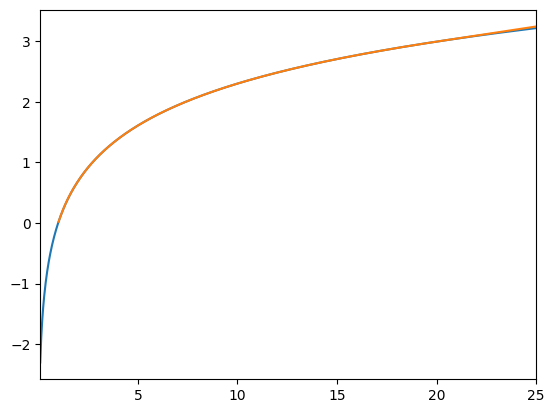

In [3]:
dYdX = 1.0 / X
h = CubicInterp(X, Y, dYdX)
plot_funcs([f, h], 0.1, 25.0)

Now the orange interpolant covers up the true blue function even at low $x$. Note that lower extrapolation is still off by default, and that linear extrapolation is used above the top gridpoint.

Accuracy is easier to see if we plot the differnce between the interpolants and the true function.

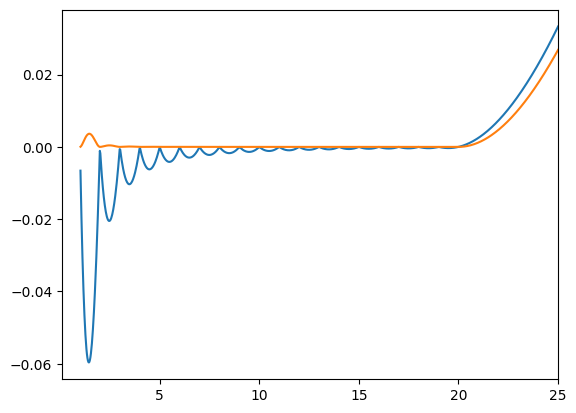

In [4]:
g_error = lambda x: g(x) - f(x)
h_error = lambda x: h(x) - f(x)
plot_funcs([g_error, h_error], 0.1, 25.0)

Here, the blue curve is the error for the linear spline interpolant and the orange curve is the error for the cubic spline interpolant. Note that the linear extrapolation is *slightly* more accurate for the cubic interpolant. That's because its initial slope is based on the *true slope* at the highest gridpoint, whereas the extrapolation for the linear spline interpolant is based on the *secant* of the two highest interpolation nodes.

`CubicInterp` has the same options as `LinearInterp` for enabling lower extrapolation (linear) and using "exponential decay" extrapolation (upper).

### Multidimensional Interpolators

`HARK.interpolation` also has multilinear interpolators for functions with 2, 3, and 4 arguments. These are, respectively, `BilinearInterp`, `TrilinearInterp`, and `QuadlinearInterp` (which maybe should be `QuadralinearInterp`).

The syntax for instantiating multilinear interpolants is *slightly* different from the 1D interpolants: the function values are passed *before* the grids rather than after. Thus the instantiating statements are formatted as:

- `f = BilinearInterp(f_values, x_grid, y_grid)`
- `g = TrilinearInterp(f_values, x_grid, y_grid, z_grid)`
- `h = QuadlinearInterp(f_values, w_grid, x_grid, y_grid, z_grid)`

Note that the *internal* names for the dimensions change from $x,y,z$ to $w,x,y,z$ when moving from 3 to 4 dimensions. This mostly only matters for calling the derivative methods (see below).

In all cases, the grids should be 1D arrays (or just lists of floats) and `f_values` should be an ND array with each dimension equal to the size of the corresponding grid. The values represent function values at the mesh of the grids.

### Who Interpolates the Interpolators? (We Do)

Partly because HARK solvers use EGM a lot, we often end up with interpolation nodes that share $y$ values but have different $x$ values within each $y$ value. For example, in `GeneralIncomeProcessModel`, permanent/persistent income is not normalized out and is present as a state variable. When using EGM, starting from a mesh grid of $(A_t, P_t)$ values will yield a set of $(M_t,P_t)$ endogenous gridpoints that share $P_t$ values but have a different set of $M_t$ values within each one. Thus `BilinearInterp` cannot be used to interpolate this data.

Instead, we construct a set of 1D interpolators over $M_t$, one for each value of $P_t$, and then *interpolate the interpolators* with the class `LinearInterpOnInterp1D`. The syntax to instantiate this class is straightforward:

`f = LinearInterpOnInterp1D(list_of_interpolants_over_x, y_grid)`

When a `LinearInterpOnInterp1D` instance is called as a function, it finds the "bounding" $y$ values for each query point, calculates the linear weight between them, and evaluates *both* "bounding" x-interpolants for each query point. It then returns the linearly weighted average of those values.

But wait, there's more! `HARK.interpolation` has this kind of interpolator for *every* possibility up to interpolants with 4 arguments. That is, the following classes can all be used with analogous syntax:

- `LinearInterpOnInterp1D` (2 arguments)
- `BilinearInterpOnInterp1D` (3 arguments)
- `TrilinearInterpOnInterp1D` (4 arguments)
- `LinearInterpOnInterp2D` (3 arguments)
- `BilinearInterpOnInterp2D` (4 arguments)
- `LinearInterpOnInterp3D` (4 arguments)

Early in HARK's development, we began coding a `BicubicInterp` interpolator, but realized that essentially no models have closed form cross-partial derivatives for their functions. This work was abandoned and is unlikely to be revived.

### Variable Lower Bounds

Sometimes the lower bound of a function's domain with respect to one dimension can depend on the value of another dimension. Most commonly in the context of consumption-saving models, the lower bound of allowable cash-on-hand can depend on other state variables, like permanent income (you can borrow more if you have higher income) or house size (you can borrow against your home).

To handle this situation with continuous state variables (rather than discrete permanent income or house size, e.g.), HARK has special interpolators with the `VariableLowerBound` prefix. These are:

- `VariableLowerBoundFunc2D`
- `VariableLowerBoundFunc3D`
- `VariableLowerBoundFunc4D`

Each of these classes has identical syntax for instantiation:

`f = VariableLowerBoundFuncND(some_ND_function, lower_bound_for_dim0_wrt_other_dims)`

The input labeled `some_ND_function` should be a callable object that takes $N=2,3,4$ arguments. Importantly, the lower bound of the first dimension (dim 0) should be zero *everywhere*. That is, `some_ND_function` should be a "regularized" or "shifted" function that aligns the lower bound to zero.

The input `lower_bound_for_dim0_wrt_other_dims` should be a callable object that takes $N-1$ arguments, representing all but the first dimension (dim 0), and returns what the *actual* lower bound is in the first dimension.

When a `VariableLowerBoundFuncND` instance is called as a function, the arguments passed to it should be the *actual* values. The class handles the shift in the first argument based on the values of the other arguments.

In practice, most interpolated functions with a strict lower boundary have the nice feature that the function goes to zero (or some other common value) at that lower bound. For any policy function for a control variable that costs money, the function *must* approach zero as cash-on-hand approaches its lowest legal value-- that's part of the definition of what it means for a state to be valid!

This is a primary reason why this "regularizing" method improves accuracy: the actual relevant state variable is cash-on-hand-above-minimum-allowable-value. The `VariableLowerBound` functionality handles the translation from raw cash-on-hand to the state space with nicer properties.

### Derivative Methods

All of the interpolator classes in HARK inherit from superclasses called `HARKinterpolatorND`, for $N=1,2,3,4$. These superclasses define an interface or API for subclasses to build from. In particular, they handle re-shaping query input and output so that the interpolators can always assume they are working with vector inputs, which simplifies programming.

In addition, the `HARKinterpolatorND` interface provides derivative methods for all interpolator classes. Specifically, the following methods are defined for *all* interplators:

- `derivativeX` : all interpolators
- `derivativeY` : 2D, 3D, and 4D interpolators
- `derivativeZ` : 3D and 4D interpolators
- `derivativeW` : 4D interpolators

These represent the first derivative with respect to those dimensions. Additionally, 1D interpolators can call the `derivative` method with no dimension named; there's no ambiguity if there's one one argument!

All of the derivative methods correctly handle calls to "sub-interpolators", including shifts from `VariableLowerBound`-- that's why we implemented the common interface! However, they do *not* currently have a backup plan if they encounter an error from trying to evaluate a derivative method on something that *doesn't have one*.

Suppose you made a `LinearInterpOnInterp1D` and one of the interpolants w.r.t $x$ wasn't a subclass of `HARKinterpolator1D`-- maybe it's some custom function that you wrote, maybe it's just a lambda function. If you try to query `MyInterpolant.derivativeX` at a point that requires calling `derivativeX` for that non-`HARKinterpolator1D` function, an error will be raised.

In the future, we will add a backup numeric derivative to prevent these kinds of errors.

## "Pseudo-Inverse" Functions

As noted above, linear spline interpolation is most accurate for functions that are not very curvy-- they are well approximated by line segments. A critical type of function in consumption-saving models is *famously* curved: the value function with risk averse preferences.

The value function with (say) CRRA preferences is built from the sum of expectations of CRRA utility terms for each period. Thus it should not be *too* surprising that value functions look *kind of like* the utility function itself. CRRA utility can be quite curved, at least when $\rho$ is not close to zero, and especially for small values of the input.

You *can* approximate a value function as a piecewise linear interpolant, but there will be a significant loss of accuracy. Moreover, if you try to explicitly maximize value using a linear spline interpolant for the value function, you will encounter some unfortunate (but explainable) numeric quirks.

HARK tries to avoid these issues by using a trick that we internally call the "pseudo-inverse". Here's the gist: if a value function is highly curved because it's a bunch of highly curved utility terms added together, then maybe it would be *less curved* if we ran it through the inverse utility function first. In this case, "maybe" turns out to be "definitely".

Whenever we refer to the "pseudo-inverse" value function, we mean the composition of the inverse utility (of consumption) function and the value function:

\begin{equation*}
\widetilde{v}(m_t) = U^{-1}(v(m_t)).
\end{equation*}

As it turns out, the pseudo-inverse value function for a consumption-saving model *looks a lot like* a typical consumption function. It is *not* the same thing as the consumption function, it just *looks like* one in terms of its shape. In particular, it goes to zero at the lower bound of cash-on-hand, asymptotes to a linear function as cash-on-hand approaches its lower bound, and asymptotes to a (usually) *different* linear function as cash-on-hand becomes arbitrarily large. (These features depend on some characteristics of the specific model). In short, the pseudo-inverse value function is "manageably curved".

Whenever a value function is represented in HARK, we convert value levels to pseudo-inverse value levels and interpolate those. The class `ValueFuncCRRA` is used to represent the value function, with the simple instantiation syntax `ValueFuncCRRA(pseudo_inverse_interpolant, CRRA)`. When the interpolant is called as a function, it evaluates the pseudo-inverse value function and then applies the utility function to "re-curve" it.

In the HARK code, we use the suffix `Nvrs` to mean "pseudo-inverse"-- it is an intentional misspelling of "inverse" because it is fake. E.g. a pseudo-inverse value function is often given the name `vNvrsFunc`.

In many consumption-saving contexts, we know the marginal value of market resources (the slope of the value function) as well as the level. To improve accuracy of the interpolant, we usually (but not always) use a `CubicInterp` to represent the pseudo-inverse marginal value function. When we do so, the slope of the pseudo-inverse value function (at its nodes) is calculated as:

\begin{equation*}
\widetilde{v}'(m_t) = v'(m_t) (U^{-1})'(v(m_t)).
\end{equation*}

If you were wondering why `HARK.rewards` has weird functions like `CRRAutility_invP` in it, this why!

To represent the marginal value function, HARK interpolates the pseudo-inverse marginal value function-- the composition of the inverse marginal utility function and the marginal value function. The interpolator class `MargValueFuncCRRA` uses analogous syntax to `ValueFuncCRRA`.

Of course, in many consumption-saving models, the marginal value function is simply the composition of the marginal utility function and the consumption function. In that case, the pseudo-inverse marginal value function *is* the consumption function!

## Lognormal Discretization

The default distribution of income shocks in HARK is a pair of permanent (or highly persistent) shocks and fully transitory shocks, both specified as lognormal (with some flexibility for representing "unemployment"). To compute expectations over income shocks, we discretize the lognormal distribution using an uncommon method, rather than Gaussian quadrature.

The default discretization method in HARK is **equiprobable**, generating $N$ nodes each with $1/N$ probability. The value of the $n$-th node equals the expectation of the distribution within its $n$-th quantile. E.g., for $N=7$, the second node is the expectation of the true distribution within about the 14th to 28th percentile (1/7 to 2/7).

The discretization method has some additional flexibility to put additional nodes in the far tails of the distribution. So in general, we want to be able to calculate the conditional expectation of a lognormal RV between two quantiles.

$\newcommand{\pbot}{\underline{p}} \newcommand{\ptop}{\overline{p}}$
$\newcommand{\qbot}{\underline{q}} \newcommand{\qtop}{\overline{q}}$
$\newcommand{\zbot}{\underline{z}} \newcommand{\ztop}{\overline{z}}$

The math for this conditional expectation doesn't seem to be well known, so we are providing it here. Let $F$ be a lognormal distribution characterized by underlying normal distribution with mean $\mu$ and standard deviation $\sigma$. Suppose we want to know the expectation of $x \sim F$ conditional on it being between the $\pbot$ and $\ptop$ quantiles, with $\pbot,\ptop \in [0,1]$ and $\pbot < \ptop$.

First, we find the upper and lower $z$ values, in terms of standard deviations from the mean. Denoting the standard normal CDF as $\Phi$:

\begin{eqnarray*}
\zbot &=& \Phi^{-1}(\pbot),\\
\ztop &=& \Phi^{-1}(\ptop).\\
\end{eqnarray*}

Next, the $z$ values are adjusted to account for the asymmetric *shape* of the lognormal distribution:

\begin{eqnarray*}
\qbot &=& \frac{\zbot - \sigma}{\sqrt{2}},\\
\qtop &=& \frac{\ztop - \sigma}{\sqrt{2}}.\\
\end{eqnarray*}

The expression for the conditional mean uses the **error function**, denoted $erf(\cdot)$, which has a domain of $\mathbb{R}$ and a range of $(-1,1)$.

\begin{equation*}
\mathbb{E} \left[ x \sim F ~\bigg|~ \pbot \leq F(x) \leq \ptop \right] = \frac{erf(\qtop) - erf(\qbot)}{2(\ptop - \pbot)} \cdot \exp(\mu + \sigma^2 / 2).
\end{equation*}

The second factor is simply the unconditional expectation of $F$.

When actually computing these values, our code sometimes uses the **complementary error function**, defined as $erfc(\cdot) \equiv 1 - erf(\cdot)$. This is because the error function approaches one as $z$ becomes large, limiting its numeric accuracy when differencing two values. Whereas $erfc$ goes to zero (from above) as $z$ becomes large, so relative numeric accuracy is preserved when comparing two "nearby" large values.